In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.api.types import CategoricalDtype
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

In [2]:
# filter features in one-hot-encoded columns with less occurences than FILTER
def filter_rare_values(one_hot_data, threshold):
    # building the sum over every column
    one_hot_result = one_hot_data
    labels = one_hot_result.columns
    sums = one_hot_result.sum()
    # iterating through columns and dropping columns with small sums
    for label, sum in zip(labels, sums):
        if sum < threshold:
            one_hot_result.drop([label], axis=1, inplace=True)
    return one_hot_result

In [3]:
# shows the gaussian normal distribution
def gaussian_graphs(mean_list, std_list, name_list, label_list, min_x, max_x):
    # building the x_values
    x_values = np.linspace(min_x, max_x, 100)
    # iterating over all parameter
    for i in range(len(mean_list[0])):
        # iterating over all classes
        for means, stds, names, label in zip(mean_list, std_list, name_list, label_list):
            # extracting the values out of the array
            mean = means[i]
            std = stds[i]
            # plotting
            if (std == 0):
                y_values = np.zeros(100)
                index = np.argwhere(x_values == mean)[0]
                y_values[index[0]] = 4
                plt.plot(x_values, y_values, label=label)
            else:
                plt.plot(x_values, norm.pdf(x_values, mean, std), label=label)
            plt.title(names[i])
        plt.legend()
        plt.show()

In [4]:
# processes one column with function and shows gaussian plot from min_x to max_x if show is True
def compute(function, datasets_old, show, min_x, max_x):
    mean_list = []
    std_list = []
    name_list = []
    label_list = []
    datasets_new = []
    for dataset in datasets_old:
        # applying function
        means, stds, names, labels, dataset_v = function(dataset)
        #appending statistics and new data
        mean_list.append(means)
        std_list.append(stds)
        name_list.append(names)
        label_list.append(labels)
        datasets_new.append(dataset_v)

    if (show):
        gaussian_graphs(mean_list, std_list, name_list, label_list, min_x, max_x)

    return datasets_new

In [5]:
def split_dataset_by_label(dataset_old):
    datasets_new = []
    for label in pd.get_dummies(dataset_old['label']).columns:
        datasets_new.append(dataset_old[dataset_old["label"] == label])
    return datasets_new

In [6]:
show = True

# Load dataset
dataset_orginal = pd.read_csv("./Homework_1_dataset.csv", sep=';', index_col=0)

# Seperate dataset by class
datasets_0 = split_dataset_by_label(dataset_orginal)

if (show):
    for dataset in datasets_0:
        print(str(dataset.iloc[0].label) + " example")
        print('-------------')
        print(dataset.iloc[0])
        print()

finance example
-------------
Auftragskonto                                                               89990201.0
Buchungstag                                                                 15.07.2016
Valutadatum                                                                 15.07.2016
Buchungstext                                                             Mieteinnahmen
Verwendungszweck                     Mietzuschuss End-To-End-Ref.: Notprovided Kund...
Beguenstigter/Zahlungspflichtiger                                          Isabel Anna
Kontonummer                                                     DE31251900019736000780
BLZ                                                                        VOHADE2HXXX
Betrag                                                                          200.00
Waehrung                                                                           EUR
label                                                                          finance
Name: 5, dtyp

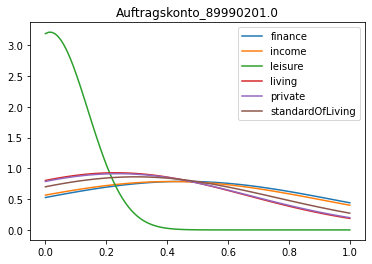

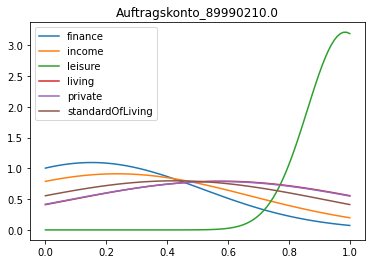

In [7]:
show = True

# Auftragskonto: one-hot-encoding 
def auftragskonto(dataset):
    # one-hot-encoding
    one_hot = pd.get_dummies(dataset['Auftragskonto'], prefix='Auftragskonto')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Auftragskonto'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_1 = compute(auftragskonto, datasets_0, show, 0, 1)

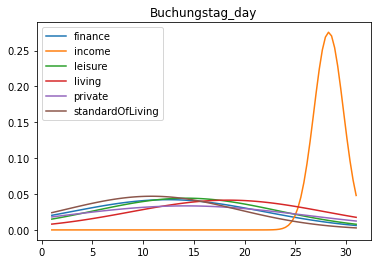

In [8]:
show = True

# Buchungstag: extracting the booking day
def bookingdate(dataset):
    # extracing the booking day
    date = pd.to_datetime(dataset['Buchungstag'], format='%d.%m.%Y')
    day = date.dt.day.to_frame(name="Buchungstag_day")
    # appending new column
    dataset = pd.concat([dataset, day], axis=1)
    # dropping old column
    dataset.drop(['Buchungstag'], axis=1, inplace=True)
    return day.mean(), day.std(), day.columns, dataset.iloc[0].label, dataset
datasets_2 = compute(bookingdate, datasets_1, show, 1, 31)

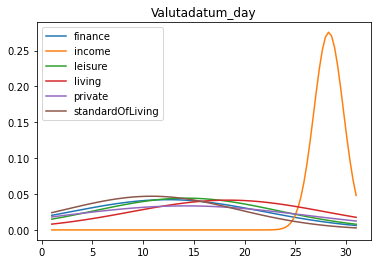

In [9]:
show = True

# Valutadatum: extracting the valuta day
def valutadate(dataset):
    # extracing the valuta day
    date = pd.to_datetime(dataset['Valutadatum'], format='%d.%m.%Y')
    day = date.dt.day.to_frame(name="Valutadatum_day")
    # appending new column
    dataset = pd.concat([dataset, day], axis=1)
    # dropping old column
    dataset.drop(['Valutadatum'], axis=1, inplace=True)
    return day.mean(), day.std(), day.columns, dataset.iloc[0].label, dataset
datasets_3 = compute(valutadate, datasets_2, show, 1, 31)

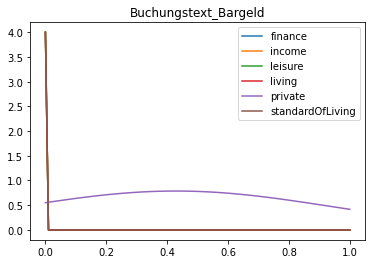

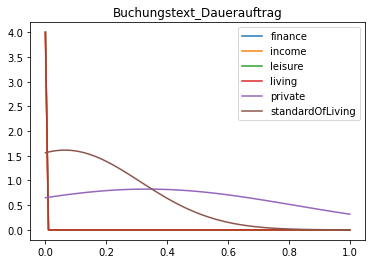

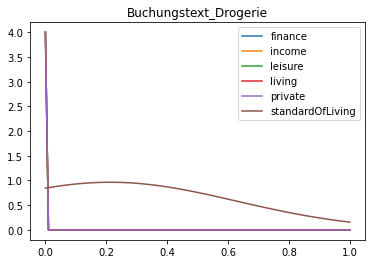

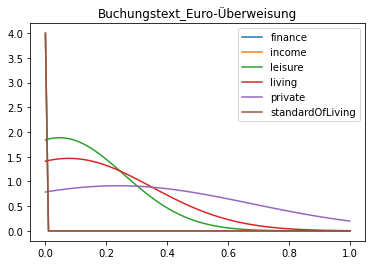

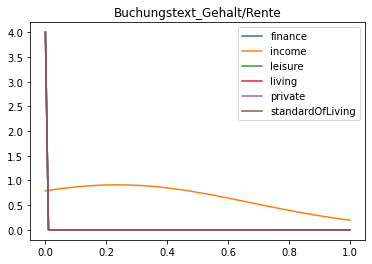

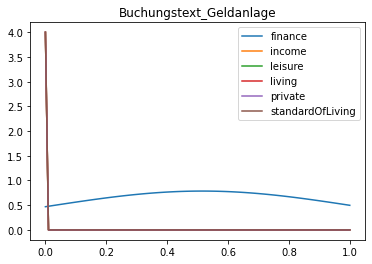

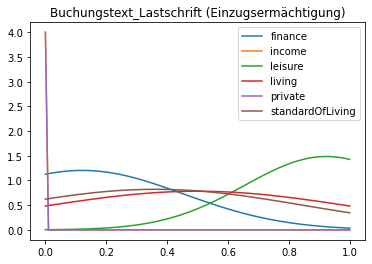

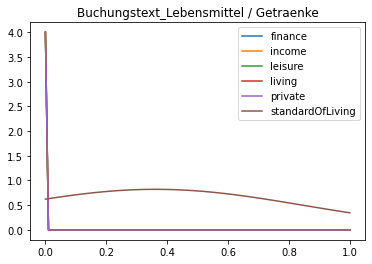

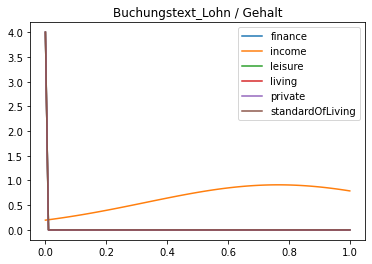

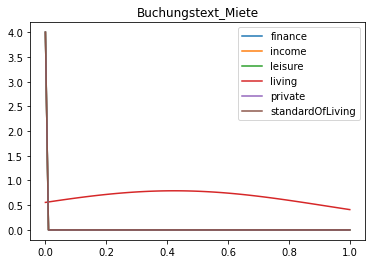

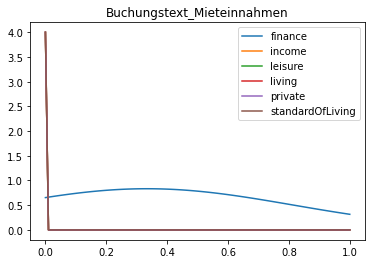

In [10]:
show = True

#Filter Hyerparmeter
FILTER = 2

# Buchungstext: one-hot-encoding with Filter
def bookingtext(dataset):
    # filtering
    dataset_filtered = filter_rare_values(pd.get_dummies(dataset_orginal['Buchungstext']), FILTER)
    # one-hot-encoding with filtered columns
    one_hot = pd.get_dummies(
        dataset['Buchungstext'].astype(CategoricalDtype(dataset_filtered.columns)), prefix='Buchungstext')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Buchungstext'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_4 = compute(bookingtext, datasets_3, True, 0, 1)

In [11]:
show = False

#Filter Hyerparmeter
FILTER = 1

# Reason: one-hot-encoding with Filter
def reason(dataset):
    # filtering
    dataset_filtered = filter_rare_values(pd.get_dummies(dataset_orginal['Verwendungszweck']), FILTER)
    # one-hot-encoding with filtered columns
    one_hot = pd.get_dummies(
        dataset['Verwendungszweck'].astype(CategoricalDtype(dataset_filtered.columns)), prefix='Verwendungszweck')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Verwendungszweck'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_5 = compute(reason, datasets_4, show, 0, 1)

In [12]:
show = False

#Filter Hyerparmeter
FILTER = 2

# People: one-hot-encoding with Filter
def people(dataset):
    # filtering
    dataset_filtered = filter_rare_values(pd.get_dummies(dataset_orginal['Beguenstigter/Zahlungspflichtiger']), FILTER)
    # one-hot-encoding with filtered columns
    one_hot = pd.get_dummies(
        dataset['Beguenstigter/Zahlungspflichtiger'].astype(CategoricalDtype(dataset_filtered.columns)), prefix='Beguenstigter/Zahlungspflichtiger')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Beguenstigter/Zahlungspflichtiger'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_6 = compute(people, datasets_5, show, 0, 1)

In [13]:
show = False

#Filter Hyerparmeter
FILTER = 2

# Number: one-hot-encoding with Filter
def number(dataset):
    # filtering
    dataset_filtered = filter_rare_values(pd.get_dummies(dataset_orginal['Kontonummer']), FILTER)
    # one-hot-encoding with filtered columns
    one_hot = pd.get_dummies(
        dataset['Kontonummer'].astype(CategoricalDtype(dataset_filtered.columns)), prefix='Kontonummer')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Kontonummer'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_7 = compute(number, datasets_6, show, 0, 1)

In [14]:
show = False

#Filter Hyerparmeter
FILTER = 2

# BLZ: one-hot-encoding with Filter
def blz(dataset):
    # filtering
    dataset_filtered = filter_rare_values(pd.get_dummies(dataset_orginal['BLZ']), FILTER)
    # one-hot-encoding with filtered columns
    one_hot = pd.get_dummies(
        dataset['BLZ'].astype(CategoricalDtype(dataset_filtered.columns)), prefix='BLZ')
    # appending new columns 
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['BLZ'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_8 = compute(blz, datasets_7, show, 0, 1)

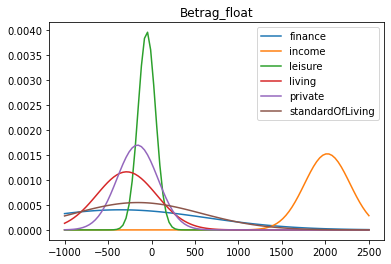

In [15]:
show = True

#amount: returns the amount in float
def amount(dataset):
    # extract day
    amount_txt = dataset['Betrag'].str.replace(',', '.')
    value = amount_txt.astype(float).to_frame().rename(columns={"Betrag": "Betrag_float"})
    # appending new column
    dataset = pd.concat([dataset, value], axis=1)
    # dropping old column
    dataset.drop(['Betrag'], axis=1, inplace=True)
    return value.mean(), value.std(), value.columns, dataset.iloc[0].label, dataset 
datasets_9 = compute(amount, datasets_8, show, -1000, 2500)

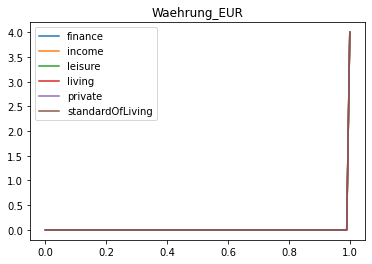

In [16]:
show = True

# Waehrung: one-hot-encoding
def currency(dataset):
    # one-hot encoding
    one_hot = pd.get_dummies(dataset['Waehrung'], prefix='Waehrung')
    # appending new columns
    dataset = pd.concat([dataset, one_hot], axis=1)
    # dropping old column
    dataset.drop(['Waehrung'], axis=1, inplace=True)
    return one_hot.mean(), one_hot.std(), one_hot.columns, dataset.iloc[0].label, dataset
datasets_10 = compute(currency, datasets_9, show, 0, 1)

In [17]:
# testing the gaussian network sample by sample and returning the score
# each sample is tested while the other are the training samples
# so we perform len(dataset)-1 times training and testing
result_list = []
predictions = []
for dataset_index, dataset in enumerate(datasets_10):
    # extracting set to test
    datasets_copy = copy.deepcopy(datasets_10)
    set = datasets_copy.pop(dataset_index)
    score = 0
    prediction = np.zeros(len(datasets_10),dtype=int)
    for index, row in set.iterrows():
        # extract test sample
        set_copy = copy.deepcopy(set)
        set_copy = set_copy.drop(labels=[index])
        # build data (other sets, other testset samples, test sample)
        data = pd.concat(datasets_copy)
        data = pd.concat([data, set_copy])
        test_sample = pd.DataFrame([row], columns=data.columns)
        data = pd.concat([data,test_sample])
        # splitting features and labels
        features = data.iloc[:,1:]
        le = LabelEncoder()
        labels = le.fit_transform(data.iloc[:,0])
        # splitting train and test data
        X_train = features.iloc[:-1]
        y_train = labels[:-1]
        X_test = features.iloc[-1]
        X_test = X_test.values.reshape(1,X_test.size)
        y_test = labels[-1].reshape(1)
        # train and test model
        model = GaussianNB()
        model.fit(X_train, y_train)
        result = model.predict(X_test)
        prediction[result] += 1
        if result == y_test:
            score += 1
    result_list.append(score)
    predictions.append(prediction)

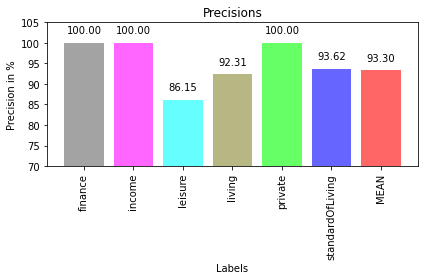

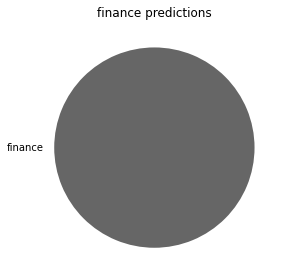

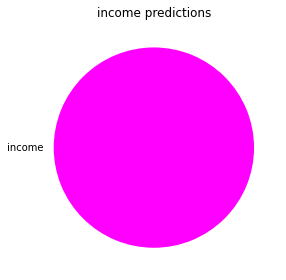

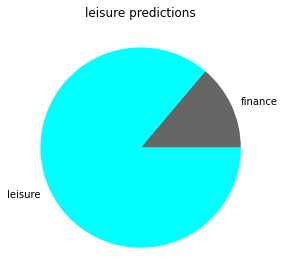

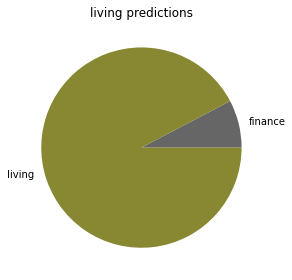

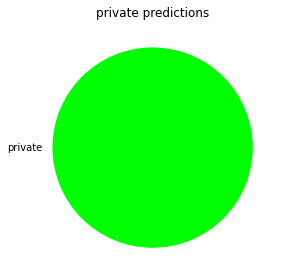

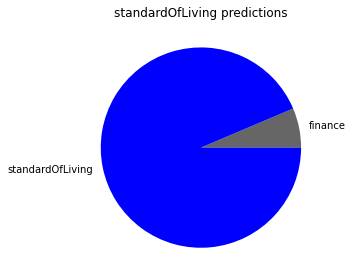

In [24]:
def autolabel(rects):
    # Attach a text label above each bar displaying its height
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 1.02*height, '%.2f' % float(height),ha='center', va='bottom')

# create labels with respective scores
score = 0
samples = 0
labels = []
scores = []
for result, set in zip(result_list, datasets_10):
    score += result
    samples  += len(set)
    labels.append(set.iloc[0].label)
    scores.append(result/len(set)*100)
labels.append("MEAN")
scores.append(score/samples*100)

# create bar graph
fig, ax = plt.subplots()
colors = ['#666666', '#ff00ff','#00ffff', '#888833', '#00ff00', '#0000ff', '#ff0000']
c_rects = plt.bar(labels, scores, align='center', alpha=0.6, color=colors)
autolabel(c_rects)
plt.ylabel('Precision in %')
plt.xlabel("Labels")
plt.xticks(rotation=90)
plt.ylim(70, 105)
plt.title("Precisions")
plt.tight_layout()
plt.savefig('prediction.png', dpi=1000)
plt.show()

# create pie charts with predictions from the test-stage
for chart_index, results in enumerate(predictions):
    labels_copy = []
    for pred_index, value in enumerate(results):
        if value>0:
            labels_copy.append(labels[pred_index])
        else:
            labels_copy.append(' ')
    plt.pie(results, labels=labels_copy, colors=colors)
    plt.title(str(labels[chart_index]) + " predictions")
    plt.savefig(str(labels[chart_index]) + " predictions"+ '.png', dpi=1000)
    plt.tight_layout()
    plt.show()